# Monk1 
Grid Search for Monk1 dataset model selection


In [1]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk1
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [2]:
training_data, training_labels, test_data, test_labels = read_monk1("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [3]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [4]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [5]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 500

if not os.path.exists('monk1_models_configs.json'):
    dir_path = "Monk1/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True, 
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=10, workers=8, number_of_initializations=5,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk1_models_configs.json')
else: 
    with open('monk1_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [6]:
models = []
with tqdm(total=len(configs)) as pbar:
    for config in configs:
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


In [62]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.11]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,History,Model,Config,Num_Layers,Num_of_Units,Name
56,0.000441,0.060177,1.0,0.001369,1.0,121,"[0.5038929971597191, 0.49411078649777956, 0.47...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.81,...",1,[5],Model54724
71,0.000518,0.063037,1.0,0.000961,1.0,163,"[0.5251269315086374, 0.5212408968514238, 0.505...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.83,...",1,[5],Model37084
0,0.000602,0.056677,1.0,0.000857,1.0,181,"[0.517969580986317, 0.5146441797194101, 0.5069...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.67,...",1,[5],Model135244
9,0.000614,0.070723,1.0,0.001043,1.0,131,"[0.5012854834814967, 0.49961221833025005, 0.49...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.89,...",1,[4],Model1803
17,0.000648,0.065802,1.0,0.001515,1.0,120,"[0.5217766758151133, 0.5172924547447367, 0.505...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.71,...",1,[4],Model112563
24,0.000750,0.060725,1.0,0.001388,1.0,142,"[0.5030641397381604, 0.5005088451121783, 0.487...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.89,...",1,[4],Model1203
36,0.000787,0.056724,1.0,0.001270,1.0,200,"[0.5080045646647818, 0.5044488784077763, 0.498...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.87,...",1,[3],Model12962
7,0.000828,0.056593,1.0,0.001493,1.0,167,"[0.5103038130862453, 0.506387328551598, 0.4943...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.82,...",1,[4],Model43208
60,0.000893,0.066017,1.0,0.001328,1.0,154,"[0.5002129308276778, 0.4992692120585916, 0.497...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.89,...",1,[4],Model2888
79,0.000963,0.054435,1.0,0.001763,1.0,190,"[0.5067313929660283, 0.5012629541197339, 0.492...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.7, ...",1,[4],Model118808


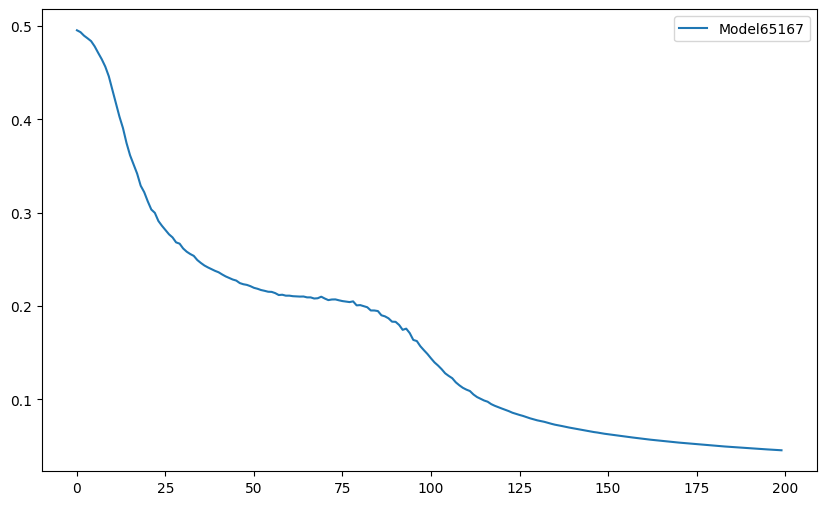

In [42]:
# plot_history(histories)

plot_history({"Model65167": histories['Model65167']})

Selected row:
Score                                                      0.000648
History_Std                                                0.065802
Accuracy                                                        1.0
Test_Score                                                 0.001515
Test_Accuracy                                                   1.0
Trained_Epochs                                                  120
History           [0.5217766758151133, 0.5172924547447367, 0.505...
Model             <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config            {'regularization': 0.0, 'learning_rate': 0.71,...
Num_Layers                                                        1
Num_of_Units                                                    [4]
Name                                                    Model112563
Name: 17, dtype: object


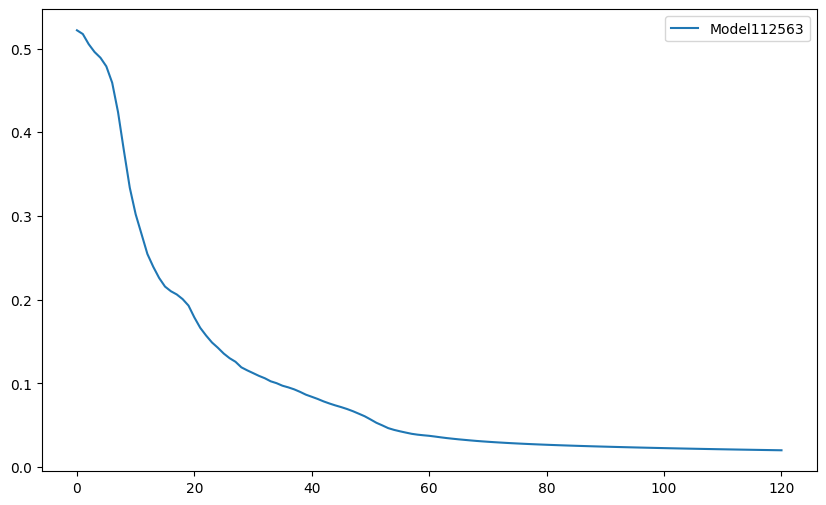

In [81]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array)/ np.mean(array))
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']})